<a href="https://colab.research.google.com/github/LeeYuuuan/ECGR-5106-HW1/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Problem 1a

## create dataset & transformation

In [72]:
batch_size = 64

In [73]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## design model

In [83]:
class My_mlp(torch.nn.Module):
    def __init__(self, input_size=3072, hidden_size=[64, 64], output_size=10):
        super(My_mlp, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size[0])


        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_size) - 1):
            self.hidden_layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))

        self.output_layer = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x


In [152]:
mlp_model

My_mlp(
  (input_layer): Linear(in_features=3072, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

## create and train model

In [150]:
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mlp_model = My_mlp().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)

In [151]:
num_epochs = 20
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    mlp_model.train()
    train_loss = 0.0
    train_acc = 0.0

    # training
    for i, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()


        train_loss += loss.item()

    train_acc /= len(trainloader.dataset)
    train_acc *= 100

    train_accs.append(train_acc)



    train_loss /= len(trainloader)
    train_losses.append(train_loss)


    # valid
    mlp_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_losses.append(test_loss)
    test_acc = 100 * correct / total
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        model_checkpoint = {
            'epoch': epoch,
            'model_state_dict': mlp_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'loss': test_loss,
            'acc': test_acc,
        }
        torch.save(model_checkpoint, f'/content/drive/MyDrive/Colab Notebooks/Real Time ML/model_check_points/model_checkpoint_{epoch}.pth') # save model every 10 epochs

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

my_model_path = "/content/drive/MyDrive/Colab Notebooks/Real Time ML/model_check_points/my_model.pth"
torch.save(mlp_model.state_dict(), my_model_path)


Epoch 1/20, Train Loss: 1.8797, Test Loss: 1.7601, Test Acc: 36.42%
Epoch 2/20, Train Loss: 1.7060, Test Loss: 1.6489, Test Acc: 41.19%
Epoch 3/20, Train Loss: 1.6496, Test Loss: 1.6160, Test Acc: 42.44%
Epoch 4/20, Train Loss: 1.5964, Test Loss: 1.5916, Test Acc: 43.52%
Epoch 5/20, Train Loss: 1.5625, Test Loss: 1.5562, Test Acc: 44.77%
Epoch 6/20, Train Loss: 1.5363, Test Loss: 1.5576, Test Acc: 45.10%
Epoch 7/20, Train Loss: 1.5135, Test Loss: 1.5641, Test Acc: 44.34%
Epoch 8/20, Train Loss: 1.4944, Test Loss: 1.5195, Test Acc: 45.90%
Epoch 9/20, Train Loss: 1.4809, Test Loss: 1.5221, Test Acc: 46.03%
Epoch 10/20, Train Loss: 1.4683, Test Loss: 1.5032, Test Acc: 46.80%
Epoch 11/20, Train Loss: 1.4556, Test Loss: 1.4830, Test Acc: 47.34%
Epoch 12/20, Train Loss: 1.4481, Test Loss: 1.5024, Test Acc: 46.69%
Epoch 13/20, Train Loss: 1.4371, Test Loss: 1.4980, Test Acc: 46.66%
Epoch 14/20, Train Loss: 1.4294, Test Loss: 1.4819, Test Acc: 47.30%
Epoch 15/20, Train Loss: 1.4203, Test Loss:

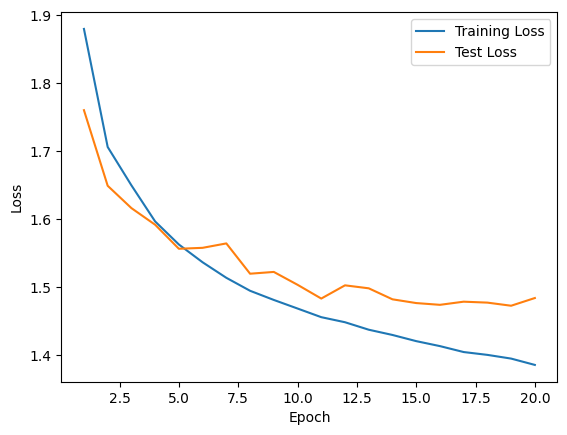

In [153]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
num_epochs = 50
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    mlp_model.train()
    train_loss = 0.0
    train_acc = 0.0

    # training
    for i, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()


        train_loss += loss.item()

    train_acc /= len(trainloader.dataset)
    train_acc *= 100

    train_accs.append(train_acc)



    train_loss /= len(trainloader)
    train_losses.append(train_loss)


    # valid
    mlp_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_losses.append(test_loss)
    test_acc = 100 * correct / total
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        model_checkpoint = {
            'epoch': epoch,
            'model_state_dict': mlp_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'loss': test_loss,
            'acc': test_acc,
        }
        torch.save(model_checkpoint, f'/content/drive/MyDrive/Colab Notebooks/Real Time ML/model_check_points/model_checkpoint_{epoch}.pth') # save model every 10 epochs

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

my_model_path = "/content/drive/MyDrive/Colab Notebooks/Real Time ML/model_check_points/my_model.pth"
torch.save(mlp_model.state_dict(), my_model_path)


Epoch 1/50, Train Loss: 1.8636, Test Loss: 1.7172, Test Acc: 38.34%
Epoch 2/50, Train Loss: 1.6958, Test Loss: 1.6551, Test Acc: 40.67%
Epoch 3/50, Train Loss: 1.6268, Test Loss: 1.6126, Test Acc: 42.31%
Epoch 4/50, Train Loss: 1.5733, Test Loss: 1.5564, Test Acc: 44.54%
Epoch 5/50, Train Loss: 1.5374, Test Loss: 1.5112, Test Acc: 46.71%
Epoch 6/50, Train Loss: 1.5141, Test Loss: 1.5295, Test Acc: 45.70%
Epoch 7/50, Train Loss: 1.4878, Test Loss: 1.5001, Test Acc: 46.24%
Epoch 8/50, Train Loss: 1.4696, Test Loss: 1.5360, Test Acc: 44.88%
Epoch 9/50, Train Loss: 1.4546, Test Loss: 1.5120, Test Acc: 46.93%
Epoch 10/50, Train Loss: 1.4386, Test Loss: 1.4972, Test Acc: 47.22%
Epoch 11/50, Train Loss: 1.4277, Test Loss: 1.4692, Test Acc: 47.50%
Epoch 12/50, Train Loss: 1.4198, Test Loss: 1.4665, Test Acc: 47.68%
Epoch 13/50, Train Loss: 1.4092, Test Loss: 1.4608, Test Acc: 48.44%
Epoch 14/50, Train Loss: 1.3955, Test Loss: 1.4677, Test Acc: 48.87%
Epoch 15/50, Train Loss: 1.3864, Test Loss:

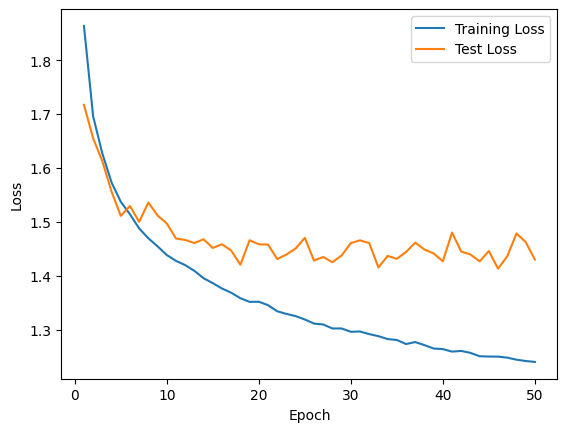

In [99]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

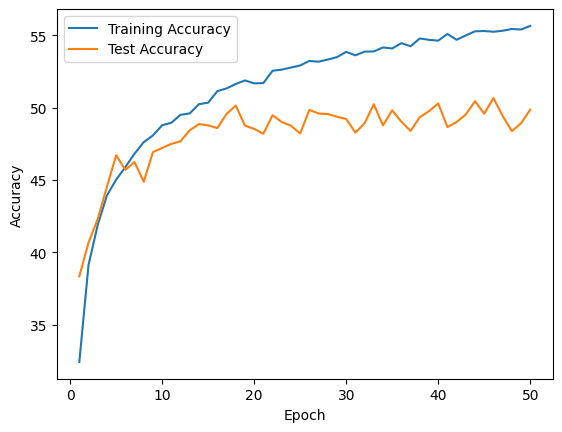

In [100]:
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## model Evaluation

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [102]:
y_true, y_pred = [], []
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

mlp_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=classes, zero_division=1)
    print(report)

              precision    recall  f1-score   support

       plane       0.66      0.46      0.54      1000
         car       0.66      0.63      0.64      1000
        bird       0.40      0.33      0.36      1000
         cat       0.38      0.26      0.31      1000
        deer       0.41      0.41      0.41      1000
         dog       0.44      0.34      0.39      1000
        frog       0.49      0.63      0.55      1000
       horse       0.45      0.64      0.53      1000
        ship       0.56      0.69      0.62      1000
       truck       0.54      0.60      0.57      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.50      0.50      0.49     10000



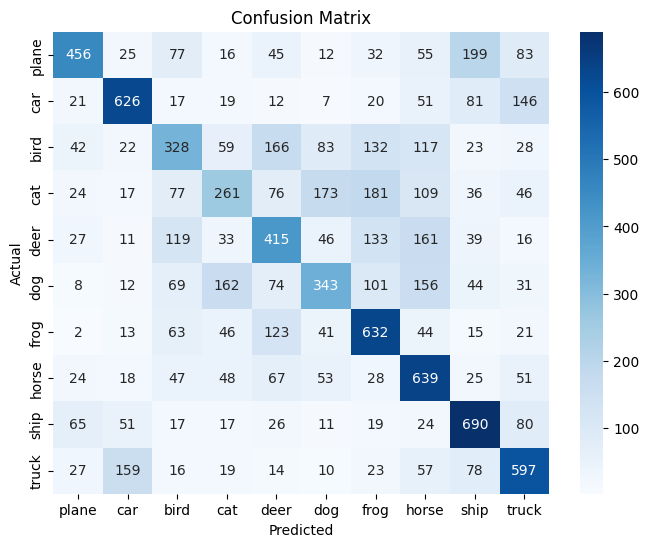

In [103]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Problem 1b

In [123]:
len(trainloader.dataset)

50000

In [139]:
def train_model(model, num_epochs):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_acc += (predicted == labels).sum().item()


            train_loss += loss.item()

        train_acc /= len(trainloader.dataset)
        train_acc *= 100
        train_accs.append(train_acc)
        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        # valid
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_acc = correct / total
        test_acc *= 100
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    train_acc = 100 * correct / total
    return train_losses, test_losses, train_accs, test_accs

In [126]:
def plot_four_losses_accs(train_losses, test_losses, train_accs, test_accs):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(4):
        plt.plot(range(1, num_epochs+1), train_losses[i], label=f'Training Loss {i+1}')
        plt.plot(range(1, num_epochs+1), test_losses[i], label=f'Test Loss {i+1}')


    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epoch')
    plt.subplot(1, 2, 2)
    for i in range(4):
        plt.plot(range(1, num_epochs+1), train_accs[i], label=f'Training Accuracy {i+1}')
        plt.plot(range(1, num_epochs+1), test_accs[i], label=f'Test Accuracy {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


## 1. reduce the model complexity

In [140]:
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mlp_model_simple_1 = My_mlp(hidden_size=[64, 64, 64]).to(device) # reduce model complexity
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model_simple_1.parameters(), lr=learning_rate)

mlp_model_simple_1_train_losses, mlp_model_simple_1_test_losses, mlp_model_simple_1_train_accs, mlp_model_simple_1_test_accs = train_model(mlp_model_simple_1, num_epochs)

Epoch 1/50, Train Loss: 1.9005, Test Loss: 1.7958, Test Acc: 35.58%
Epoch 2/50, Train Loss: 1.7216, Test Loss: 1.6543, Test Acc: 40.66%
Epoch 3/50, Train Loss: 1.6561, Test Loss: 1.6094, Test Acc: 42.84%
Epoch 4/50, Train Loss: 1.6030, Test Loss: 1.5882, Test Acc: 42.79%
Epoch 5/50, Train Loss: 1.5582, Test Loss: 1.6269, Test Acc: 42.56%
Epoch 6/50, Train Loss: 1.5276, Test Loss: 1.5108, Test Acc: 46.05%
Epoch 7/50, Train Loss: 1.5019, Test Loss: 1.5202, Test Acc: 45.49%
Epoch 8/50, Train Loss: 1.4822, Test Loss: 1.5356, Test Acc: 45.65%
Epoch 9/50, Train Loss: 1.4688, Test Loss: 1.4944, Test Acc: 46.66%
Epoch 10/50, Train Loss: 1.4571, Test Loss: 1.5041, Test Acc: 45.61%
Epoch 11/50, Train Loss: 1.4373, Test Loss: 1.5093, Test Acc: 46.63%
Epoch 12/50, Train Loss: 1.4279, Test Loss: 1.4648, Test Acc: 47.94%
Epoch 13/50, Train Loss: 1.4141, Test Loss: 1.4766, Test Acc: 47.25%
Epoch 14/50, Train Loss: 1.4060, Test Loss: 1.4794, Test Acc: 46.93%
Epoch 15/50, Train Loss: 1.3996, Test Loss:

## improve model complexity

In [141]:
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mlp_model_complex_1 = My_mlp(hidden_size=[256, 256, 128, 128, 64]).to(device) # improve model complexity
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model_complex_1.parameters(), lr=learning_rate)
mlp_model_complex_1_train_losses, mlp_model_complex_1_test_losses, mlp_model_complex_1_train_accs, mlp_model_complex_1_test_accs = train_model(mlp_model_complex_1, num_epochs)

Epoch 1/50, Train Loss: 1.9875, Test Loss: 1.8287, Test Acc: 32.44%
Epoch 2/50, Train Loss: 1.7773, Test Loss: 1.7106, Test Acc: 38.02%
Epoch 3/50, Train Loss: 1.6912, Test Loss: 1.6565, Test Acc: 40.95%
Epoch 4/50, Train Loss: 1.6188, Test Loss: 1.6311, Test Acc: 40.69%
Epoch 5/50, Train Loss: 1.5661, Test Loss: 1.5580, Test Acc: 43.98%
Epoch 6/50, Train Loss: 1.5230, Test Loss: 1.5260, Test Acc: 45.57%
Epoch 7/50, Train Loss: 1.4894, Test Loss: 1.5260, Test Acc: 45.32%
Epoch 8/50, Train Loss: 1.4532, Test Loss: 1.4737, Test Acc: 47.49%
Epoch 9/50, Train Loss: 1.4243, Test Loss: 1.4708, Test Acc: 47.58%
Epoch 10/50, Train Loss: 1.3991, Test Loss: 1.4548, Test Acc: 47.79%
Epoch 11/50, Train Loss: 1.3745, Test Loss: 1.4836, Test Acc: 47.99%
Epoch 12/50, Train Loss: 1.3507, Test Loss: 1.4607, Test Acc: 48.08%
Epoch 13/50, Train Loss: 1.3284, Test Loss: 1.4635, Test Acc: 48.45%
Epoch 14/50, Train Loss: 1.3074, Test Loss: 1.4528, Test Acc: 49.77%
Epoch 15/50, Train Loss: 1.2897, Test Loss:

In [142]:
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mlp_model_complex_2 = My_mlp(hidden_size=[256, 256, 128, 128, 128, 64]).to(device) # improve model complexity
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model_complex_2.parameters(), lr=learning_rate)
mlp_model_complex_2_train_losses, mlp_model_complex_2_test_losses, mlp_model_complex_2_train_accs, mlp_model_complex_2_test_accs = train_model(mlp_model_complex_2, num_epochs)
#

Epoch 1/50, Train Loss: 2.0153, Test Loss: 1.8469, Test Acc: 30.30%
Epoch 2/50, Train Loss: 1.8045, Test Loss: 1.7336, Test Acc: 36.43%
Epoch 3/50, Train Loss: 1.7163, Test Loss: 1.6946, Test Acc: 38.29%
Epoch 4/50, Train Loss: 1.6348, Test Loss: 1.5976, Test Acc: 42.69%
Epoch 5/50, Train Loss: 1.5802, Test Loss: 1.5574, Test Acc: 43.99%
Epoch 6/50, Train Loss: 1.5427, Test Loss: 1.5390, Test Acc: 44.49%
Epoch 7/50, Train Loss: 1.5085, Test Loss: 1.5388, Test Acc: 44.90%
Epoch 8/50, Train Loss: 1.4814, Test Loss: 1.5249, Test Acc: 45.14%
Epoch 9/50, Train Loss: 1.4559, Test Loss: 1.5499, Test Acc: 44.47%
Epoch 10/50, Train Loss: 1.4306, Test Loss: 1.5104, Test Acc: 46.26%
Epoch 11/50, Train Loss: 1.4121, Test Loss: 1.4750, Test Acc: 47.97%
Epoch 12/50, Train Loss: 1.3878, Test Loss: 1.4629, Test Acc: 48.33%
Epoch 13/50, Train Loss: 1.3704, Test Loss: 1.4584, Test Acc: 48.71%
Epoch 14/50, Train Loss: 1.3532, Test Loss: 1.4769, Test Acc: 47.92%
Epoch 15/50, Train Loss: 1.3338, Test Loss:

## plot

In [131]:
len(mlp_model_simple_1_train_losses)

50

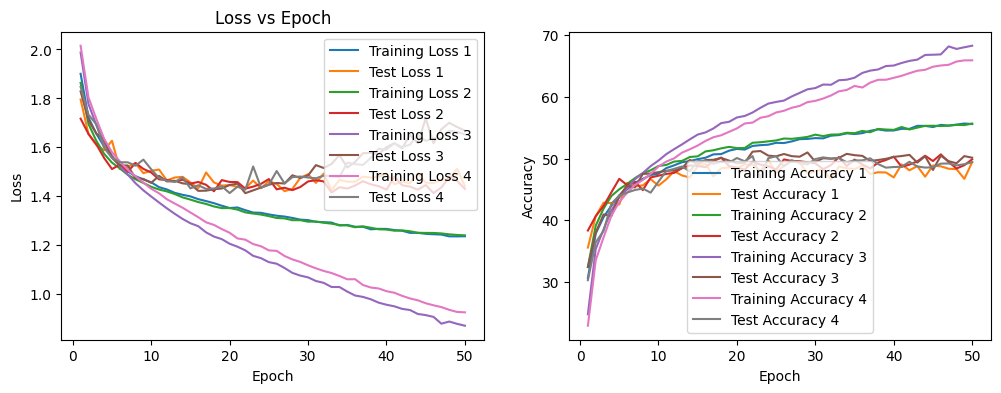

In [143]:
plot_four_losses_accs([mlp_model_simple_1_train_losses, train_losses, mlp_model_complex_1_train_losses, mlp_model_complex_2_train_losses],
                      [mlp_model_simple_1_test_losses, test_losses, mlp_model_complex_1_test_losses, mlp_model_complex_2_test_losses],
                      [mlp_model_simple_1_train_accs, train_accs, mlp_model_complex_1_train_accs, mlp_model_complex_2_train_accs],
                      [mlp_model_simple_1_test_accs, test_accs, mlp_model_complex_1_test_accs, mlp_model_complex_2_test_accs])


## for more details

In [144]:
def plot_acc(train_accs, test_accs):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(4):
        plt.plot(range(1, num_epochs+1), train_accs[i], label=f'Training Accuracy {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('training Accuracy')
    plt.legend()

    plt.title('training Accuracy vs Epoch')
    plt.subplot(1, 2, 2)
    for i in range(4):
        plt.plot(range(1, num_epochs+1), test_accs[i], label=f'Test Accuracy {i+1}')


    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.title('Test Accuracy vs Epoch')
    plt.show()


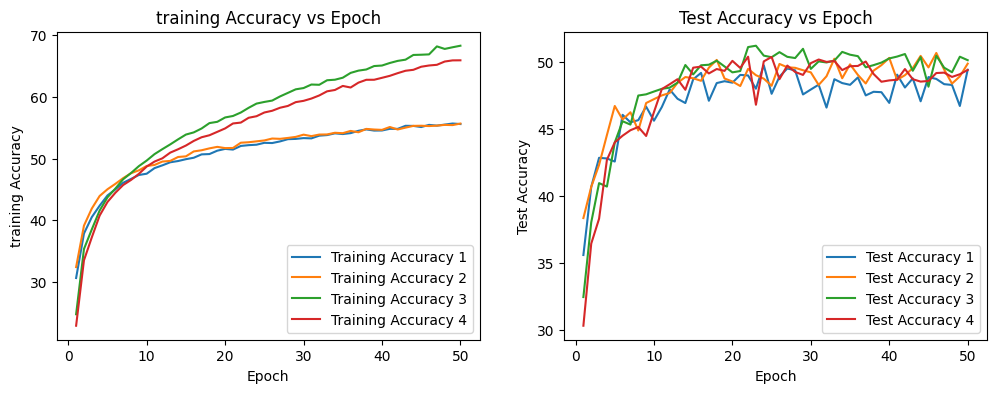

In [145]:
plot_acc([mlp_model_simple_1_train_accs, train_accs, mlp_model_complex_1_train_accs, mlp_model_complex_2_train_accs],
         [mlp_model_simple_1_test_accs, test_accs, mlp_model_complex_1_test_accs, mlp_model_complex_2_test_accs])

In [146]:
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(4):
        plt.plot(range(1, num_epochs+1), train_losses[i], label=f'Training Loss {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('training Loss')
    plt.legend()

    plt.title('training Loss vs Epoch')
    plt.subplot(1, 2, 2)
    for i in range(4):
        plt.plot(range(1, num_epochs+1), test_losses[i], label=f'Test Loss {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.title('Test Loss vs Epoch')
    plt.show()


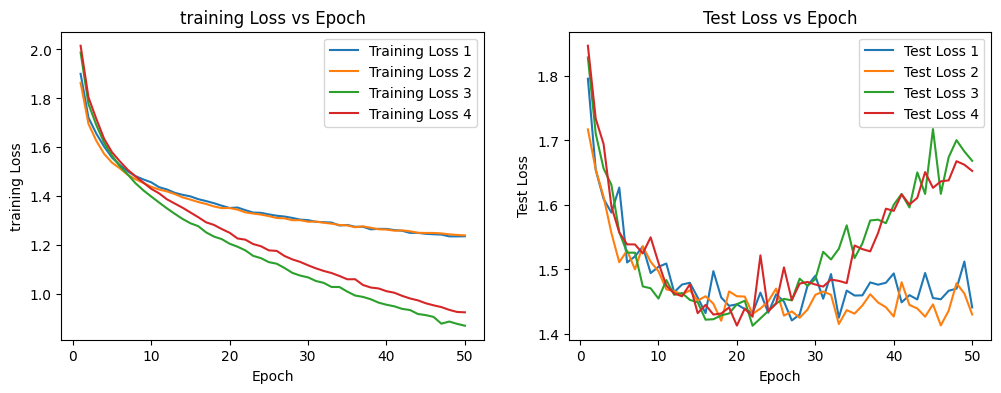

In [147]:
plot_loss([mlp_model_simple_1_train_losses, train_losses, mlp_model_complex_1_train_losses, mlp_model_complex_2_train_losses],
          [mlp_model_simple_1_test_losses, test_losses, mlp_model_complex_1_test_losses, mlp_model_complex_2_test_losses])